In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
import scipy.stats as stats
import scipy.interpolate as inter
import plotly.express as px
from sklearn import preprocessing as skprep
import numba
import timeit
import math
import itertools
from pprint import pprint

In [62]:
def norm(x):
    return (x - x.min()) / (x.max() - x.min())

In [63]:
def f_test(x, y):
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1) / np.var(y, ddof=1)  #calculate F test statistic
    dfn = x.size - 1  #define degrees of freedom numerator
    dfd = y.size - 1  #define degrees of freedom denominator
    p = 1 - stats.f.cdf(f, dfn, dfd)  #find p-value of F test statistic
    return f, p

In [64]:
def get_metrics(prediction, labels):
    tp = (prediction & labels).sum()
    tn = (~prediction & ~labels).sum()
    fp = (prediction & ~labels).sum()
    fn = (~prediction & labels).sum()
    precition = tp / (tp + fp)
    recall = tp / (tp + fn)
    return {
        "[tp, fp]": [tp, fp],
        "[fn, tn]": [fn, tn],
        "precition": precition,
        "recall": recall
    }

In [65]:
df = pd.read_csv("DataSet2_1.csv", sep='|')
df = df.dropna()
#
# df["Day"] = pd.to_datetime(df["Day"])
# df["Day"] = norm(df["Day"].values.astype("float64"))
#
# df = df.drop(columns=[
#     'Entity', 'Code', 'Year', 'Continent'
# ])
# df = df.drop_duplicates()
# df = df.reset_index(drop=True)
#
# df = df.groupby(by="Day").sum()
# df = df.reset_index()
#
predict_column = "fraud"

columns = list(df.columns)
columns.remove(predict_column)
columns = pd.Index(columns)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1879 entries, 0 to 1878
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   trustLevel                 1879 non-null   int64  
 1   totalScanTimeInSeconds     1879 non-null   int64  
 2   grandTotal                 1879 non-null   float64
 3   lineItemVoids              1879 non-null   int64  
 4   scansWithoutRegistration   1879 non-null   int64  
 5   quantityModifications      1879 non-null   int64  
 6   scannedLineItemsPerSecond  1879 non-null   float64
 7   valuePerSecond             1879 non-null   float64
 8   lineItemVoidsPerPosition   1879 non-null   float64
 9   fraud                      1879 non-null   int64  
dtypes: float64(4), int64(6)
memory usage: 146.9 KB


In [66]:
df.nunique()

trustLevel                      6
totalScanTimeInSeconds       1193
grandTotal                   1721
lineItemVoids                  12
scansWithoutRegistration       11
quantityModifications           6
scannedLineItemsPerSecond    1772
valuePerSecond               1879
lineItemVoidsPerPosition      216
fraud                           2
dtype: int64

In [67]:
df["fraud"].value_counts()

0    1775
1     104
Name: fraud, dtype: int64

In [68]:
df_train = df.sample(200)
df_test = df[~df.index.isin(df_train.index)]

df_train_index = df_test.index.copy()
df_test = df_test.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)

len(df_test), len(df_train)

(1679, 200)

In [69]:
data = dict()

# Logreg

In [70]:
from sklearn.linear_model import LogisticRegression

X = df_train[columns]
y = df_train[predict_column]

clf = LogisticRegression(random_state=0).fit(X, y)

clf.predict(df_test[columns])

C:\Users\kolya\miniconda3\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [71]:
get_metrics(clf.predict(df_test[columns]).astype(bool), df_test[predict_column].astype(bool))

{'[tp, fp]': [11, 6],
 '[fn, tn]': [84, 1578],
 'precition': 0.6470588235294118,
 'recall': 0.11578947368421053}

C:\Users\kolya\miniconda3\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


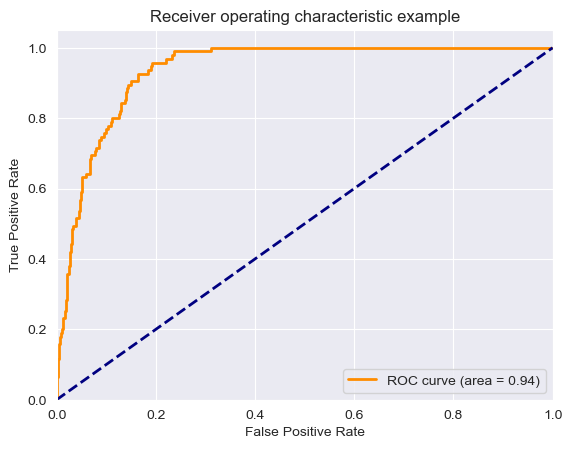

In [72]:
from sklearn.metrics import roc_curve, auc

y_score = clf.fit(X, y).decision_function(df_test[columns])

fpr, tpr, _ = roc_curve(df_test[predict_column], y_score)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
data["Logreg"] = {
    "fpr": fpr,
    "tpr": tpr,
    "lw": lw,
    "roc_auc": roc_auc,
}
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [73]:
clf.fit(X, y).decision_function(df_test[columns])

C:\Users\kolya\miniconda3\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([-10.43777568,  -6.78654778, -11.81696813, ...,  -6.35109817,
        -3.45144389,  -8.74482959])

# SVM

In [74]:
from sklearn import svm

X = df_train[columns]
y = df_train[predict_column]

clf = svm.LinearSVC()
clf.fit(X, y)

clf.predict(df_test[columns])

C:\Users\kolya\miniconda3\envs\tf\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [75]:
get_metrics(clf.predict(df_test[columns]).astype(bool), df_test[predict_column].astype(bool))

{'[tp, fp]': [30, 203],
 '[fn, tn]': [65, 1381],
 'precition': 0.12875536480686695,
 'recall': 0.3157894736842105}

C:\Users\kolya\miniconda3\envs\tf\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


array([-0.97569979, -0.95332809, -1.89169036, ..., -1.62458684,
       -1.84001553, -1.11016066])


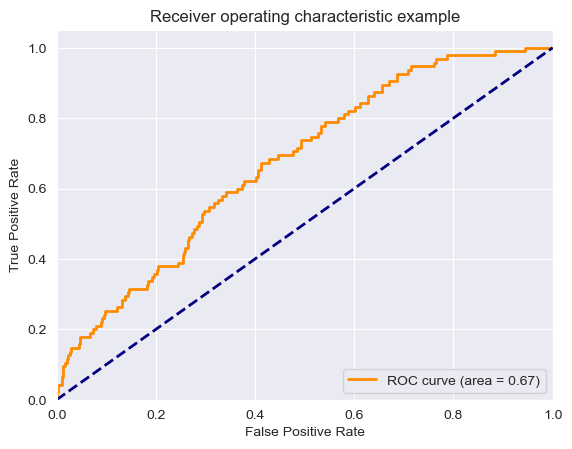

In [76]:
from sklearn.metrics import roc_curve, auc

y_score = clf.fit(X, y).decision_function(df_test[columns])
pprint(y_score)
fpr, tpr, _ = roc_curve(df_test[predict_column], y_score)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
data["SVM"] = {
    "fpr": fpr,
    "tpr": tpr,
    "lw": lw,
    "roc_auc": roc_auc,
}
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [77]:
clf.fit(X, y).decision_function(df_test[columns])

C:\Users\kolya\miniconda3\envs\tf\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


array([-1.06160705, -0.89079203, -2.03563332, ..., -1.55437126,
       -1.80962855, -1.2588262 ])

# Дерево

In [78]:
from sklearn import tree

X = df_train[columns]
y = df_train[predict_column]

clf = tree.DecisionTreeClassifier()
clf.fit(X, y)

clf.predict(df_test[columns])

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [79]:
get_metrics(clf.predict(df_test[columns]).astype(bool), df_test[predict_column].astype(bool))

{'[tp, fp]': [29, 29],
 '[fn, tn]': [66, 1555],
 'precition': 0.5,
 'recall': 0.30526315789473685}

array([[   0, 1618],
       [   1,   61]])


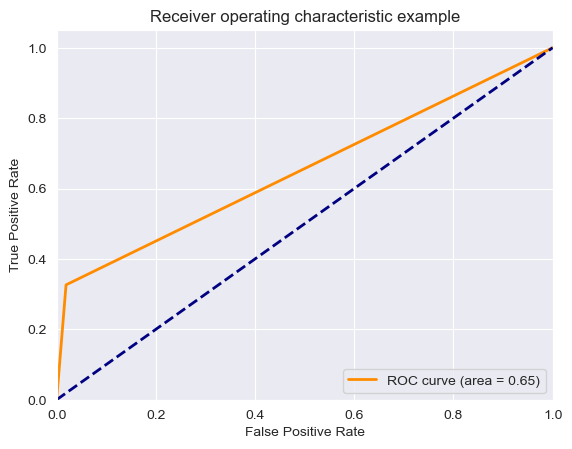

In [80]:
from sklearn.metrics import roc_curve, auc

y_score = clf.fit(X, y).predict_proba(df_test[columns])
pprint(np.asarray(np.unique(y_score[:, 1], return_counts=True), dtype=int).T)

fpr, tpr, _ = roc_curve(df_test[predict_column], y_score[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
data["Tree"] = {
    "fpr": fpr,
    "tpr": tpr,
    "lw": lw,
    "roc_auc": roc_auc,
}
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

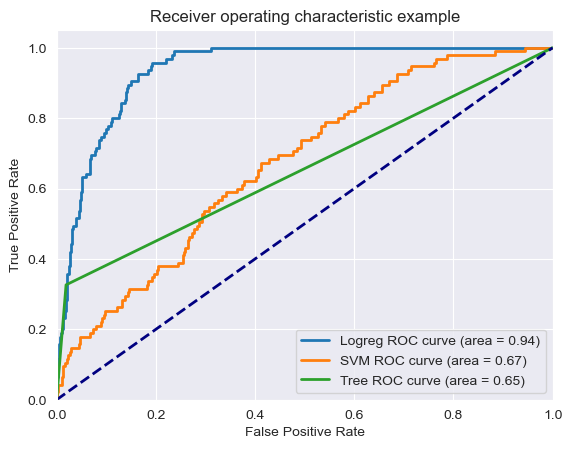

In [85]:
for k, v in data.items():
    plt.plot(
        v["fpr"],
        v["tpr"],
        lw=v["lw"],
        label="%s ROC curve (area = %0.2f)" % (k, v["roc_auc"]),
    )
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()